# FIN 514 - Crank-Nicolson Finite Difference - American options
**Spring 2021**

This notebook provides two differeny Crank-Nicolson Finite Difference Code to value American style options. We'll use the case in PS3 as the benchmark

## Packages and Configurations

The following common packages will be use on this notebook.

* numpy - [https://numpy.org/](https://numpy.org/)
* Pandas - [https://pandas.pydata.org/](https://pandas.pydata.org/)
* matplotlib - [https://matplotlib.org/](https://matplotlib.org/)
* Scipy Statistical functions - [https://docs.scipy.org/doc/scipy/reference/stats.html](https://docs.scipy.org/doc/scipy/reference/stats.html)


In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
# ENTER INPUT FOR: start_step


#jmax = 100 #Number of S steps
imax = 5000 #Number of t steps
S0 = 100.0
K = 105.0
sigma = 0.2
r = 0.01
q = 0
T = 0.5
SL = 0 #Minimum S value
SU = 2.5*S0 #Maximum S value

## Crank-Nicolson Finite Difference Function - simple early exercise

In [3]:

def CNFD_model(S0, K, T, r, q, sigma, SU, jmaxmin, jmaxmax, jmaxstep, imax):
    
    #LIST TO SAVE RESULTS
    #Assumes that SL= 0, can be relaxed, see notes for updates A, B, C values in this case
    
    cnfd_result = []
    
    for jmax in range(jmaxmin, jmaxmax, jmaxstep): 
    
    # CREATE TWO DIMENSIONAL ARRAY OF SIZE [imax+1,jmax+1] TO STORE V AT ALL STEPS
    # V[imax, jmax]
    
        V = np.zeros([imax+1, jmax+1])

    # CREATE ONE DIMENSIONAL ARRAY OF SIZE [jmax+1] TO STORE A, B, C VALUES AT ALL STEPS
    # A[jmax], B[jmax], C[jmax] 
    
        A = np.zeros([jmax+1])
        B = np.zeros([jmax+1])
        C = np.zeros([jmax+1])
        D = np.zeros([jmax+1])
        alpha = np.zeros([jmax+1])
        CN_S = np.zeros([jmax+1])
    
    # Set up time and S steps
    
        dt = T / imax
        dS = SU/jmax
       
        
    # CALCULATE OPTION VALUES AND PROBABILITIES
    # Start at the last step number because we are going to be moving backwards from times step imax to times step 0
    
        i = imax 
        
        for j in range(0, jmax+1):    
    # Then, calculate the value of the option at that exact position within the binomial tree
    # Also calculate the probabilities A, B, C
           
            V[i, j] = np.maximum(K-j*dS, 0)
            A[j] = 0.25*sigma**2*j**2 - 0.25*(r-q)*j
            B[j] = -1/dt-0.5*r-0.5*sigma**2*j**2
            C[j] = 0.25*sigma**2*j**2 + 0.25*(r-q)*j

    #Now go back in time
        for i in range(imax-1, -1, -1):

            #Lower boundary condition in matrix terms
            A[0] = 0
            B[0] = 1
            C[0] = 0
            D[0] = K
    
            #regular D values
            for j in range(1, jmax, 1):
                
                D1 = -V[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r-q)*j)
                D2 = -V[i+1,j]*(1/dt-0.5*r-0.5*sigma**2*j**2)
                D3 = -V[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r-q)*j)
                D[j] = D1+D2+D3
            
            #Upper boundary condition in matrix terms
            A[jmax] = 0
            B[jmax] = 1
            C[jmax] = 0
            D[jmax] = 0
            
            
            alpha[0] = B[0]
            CN_S[0] = D[0]
            for j in range(1, jmax+1, 1):
                alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]  
            V[i,jmax] = CN_S[jmax]/alpha[jmax]
            for j in range(jmax-1,-1,-1):
                V[i,j] = np.maximum((CN_S[j]-C[j]*V[i,j+1])/alpha[j],K-j*dS)
                
                
    # RELAY OUTPUTS TO DICTIONARY
        jcritreal = S0/dS
        jcrit = int(jcritreal)
        jcritK = int(K/dS)+1
        Vcrit = V[0,jcrit]+ (S0 - jcrit * dS) / (dS) * (V[0,jcrit+1] - V[0,jcrit])
        Klambda = (jcritK*dS - K)/dS
        output = {'S_steps': jmax, 't_steps': imax, 'CN': Vcrit, 'Lambda': Klambda}
        cnfd_result.append(output)

    return cnfd_result


In [4]:
cnfd = CNFD_model(S0, K, T, r, q, sigma, SU, 50, 500, 50, 5000)

In [5]:
exact = 8.33527781

In [6]:
# CREATE A DATAFRAME FROM THE BINOMIAL MODEL OUTPUT
df = pd.DataFrame.from_dict(cnfd)

In [7]:
# CALCULATE THE ERROR FROM BINOMIAL MODEL COMPARED WITH BLACK-SHCOLES
df['error_cn'] = df["CN"] - exact 
df

,S_steps,t_steps,CN,Lambda,error_cn
0,50,5000,8.249332,1.0,-0.085946
1,100,5000,8.313421,1.0,-0.021856
2,150,5000,8.325451,1.0,-0.009827
3,200,5000,8.329706,1.0,-0.005572
4,250,5000,8.331689,1.0,-0.003588
5,300,5000,8.332772,1.0,-0.002506
6,350,5000,8.333427,1.0,-0.001851
7,400,5000,8.333853,1.0,-0.001425
8,450,5000,8.334145,1.0,-0.001132


In [8]:
# EXPORT THE DATA TO A CSV FILE
df.to_csv("Data/cn.csv", index=False)

CN finite difference error profile with varying lambda

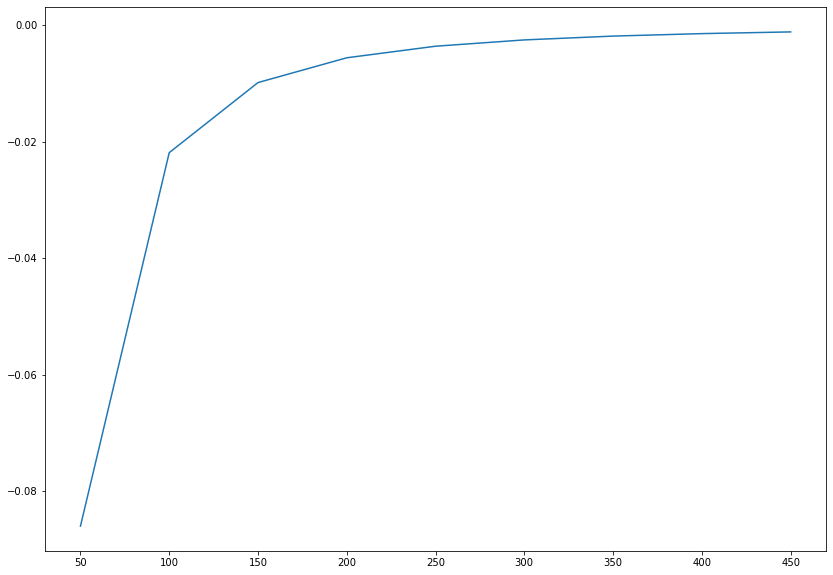

In [9]:
plt.figure(figsize=(14,10))
plt.plot(df['S_steps'], df['error_cn'], '-', markersize=3)
plt.savefig('Images/cnus1.png')
plt.show()

In [10]:

def CNFD(i,j,jp,jmax,sigma,r,K,dt,dS,V):
    
    #This is the subroutine that does a CN valuation
    
    for j in range(0, jp): 
    
    # jp is the end of early exercise range 
    
        V[i,j] = K -j*dS

    # CREATE ONE DIMENSIONAL ARRAY OF SIZE [jmax+1] TO STORE A, B, C VALUES AT ALL STEPS
    # A[jmax], B[jmax], C[jmax] 
    
    A = np.zeros([jmax+1])
    B = np.zeros([jmax+1])
    C = np.zeros([jmax+1])
    D = np.zeros([jmax+1])
    alpha = np.zeros([jmax+1])
    CN_S = np.zeros([jmax+1])
    
    # Set up time and S steps
    
#Lower boundary condition in matrix terms
    A[jp] = 0
    B[jp] = 1
    C[jp] = 0
    D[jp] = K - jp*dS

        #regular D values
    for j in range(jp+1, jmax, 1):

        A[j] = 0.25*sigma**2*j**2 - 0.25*(r-q)*j
        B[j] = -1/dt-0.5*r-0.5*sigma**2*j**2
        C[j] = 0.25*sigma**2*j**2 + 0.25*(r-q)*j
        D1 = -V[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r-q)*j)
        D2 = -V[i+1,j]*(1/dt-0.5*r-0.5*sigma**2*j**2)
        D3 = -V[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r-q)*j)
        D[j] = D1+D2+D3

    #Upper boundary condition in matrix terms
    A[jmax] = 0
    B[jmax] = 1
    C[jmax] = 0
    D[jmax] = 0


    alpha[jp] = B[jp]
    CN_S[jp] = D[jp]
    for j in range(jp+1, jmax+1, 1):
        alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
        CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]  
    V[i,jmax] = CN_S[jmax]/alpha[jmax]
    for j in range(jmax-1,jp,-1):
        V[i,j] = (CN_S[j]-C[j]*V[i,j+1])/alpha[j]

    return V


## Advanced model with iterated exercise boundary

In [11]:

def CNFD_adv_model(S0, K, T, r, q, sigma, SU, jmaxmin, jmaxmax, jmaxstep, imax, itmax):
    
    #LIST TO SAVE RESULTS
    #Assumes that SL= 0, can be relaxed, see notes for updates A, B, C values in this case
    
    cnadvfd_result = []
    
    for jmax in range(jmaxmin, jmaxmax, jmaxstep): 
    
    # CREATE TWO DIMENSIONAL ARRAY OF SIZE [imax+1,jmax+1] TO STORE V AT ALL STEPS
    # V[imax, jmax]
    
        V = np.zeros([imax+1, jmax+1])

    # CREATE ONE DIMENSIONAL ARRAY OF SIZE [jmax+1] TO STORE A, B, C VALUES AT ALL STEPS
    # A[jmax], B[jmax], C[jmax] 

        ex = np.zeros([imax+1])
    
    # Set up time and S steps
    
        dt = T / imax
        dS = SU/jmax
       
        
    # CALCULATE OPTION VALUES AND PROBABILITIES
    # Start at the last step number because we are going to be moving backwards from times step imax to times step 0
    
        i = imax 
        
        for j in range(0, jmax+1):    
    # Then, calculate the value of the option at that exact position within the binomial tree
    # Also calculate the probabilities A, B, C
           
            V[i, j] = np.maximum(K-j*dS, 0)
            if (V[i,j] > 0): jp = j
            ex[i] = jp

    #Now go back in time
        for i in range(imax-1, -1, -1):
            jp = jp-1
            for it in range (1,itmax):
                V = CNFD(i,j,jp,jmax,sigma,r,K,dt,dS,V)
                cv = 0.5*(V[i,jp+1]+V[i+1,jp+1])
                if (K - (jp+1)*dS < cv):
                    jp = jp-1
                else:
                    jp = jp+1
                    V = CNFD(i,j,jp,jmax,sigma,r,K,dt,dS,V)
                    ex[i] = jp
                    #print ("i = ", i, "boundary = ", ex[i])
                    break
                    
    # RELAY OUTPUTS TO DICTIONARY
        jcritreal = S0/dS
        jcrit = int(jcritreal)
        jcritK = int(K/dS)+1
        Vcrit = V[0,jcrit]+ (S0 - jcrit * dS) / (dS) * (V[0,jcrit+1] - V[0,jcrit])
        Klambda = (jcritK*dS - K)/dS
        output = {'S_steps': jmax, 't_steps': imax, 'CN': Vcrit, 'Lambda': Klambda}
        cnadvfd_result.append(output)

    return cnadvfd_result


In [12]:
cnadvfd = CNFD_adv_model(S0, K, T, r, q, sigma, SU, 50, 500, 50, 5000, 100)

In [13]:
# CREATE A DATAFRAME FROM THE BINOMIAL MODEL OUTPUT
df = pd.DataFrame.from_dict(cnadvfd)
df

,S_steps,t_steps,CN,Lambda
0,50,5000,8.242405,1.0
1,100,5000,8.311184,1.0
2,150,5000,8.324367,1.0
3,200,5000,8.329065,1.0
4,250,5000,8.331268,1.0
5,300,5000,8.332473,1.0
6,350,5000,8.333206,1.0
7,400,5000,8.333682,1.0
8,450,5000,8.334011,1.0


In [14]:
# CALCULATE THE ERROR FROM BINOMIAL MODEL COMPARED WITH BLACK-SHCOLES
df['error_cn'] = df["CN"] - exact
df

,S_steps,t_steps,CN,Lambda,error_cn
0,50,5000,8.242405,1.0,-0.092873
1,100,5000,8.311184,1.0,-0.024093
2,150,5000,8.324367,1.0,-0.010911
3,200,5000,8.329065,1.0,-0.006213
4,250,5000,8.331268,1.0,-0.004010
5,300,5000,8.332473,1.0,-0.002804
6,350,5000,8.333206,1.0,-0.002072
7,400,5000,8.333682,1.0,-0.001596
8,450,5000,8.334011,1.0,-0.001266


### Crank-Nicolson finite difference error profile with advanced model 

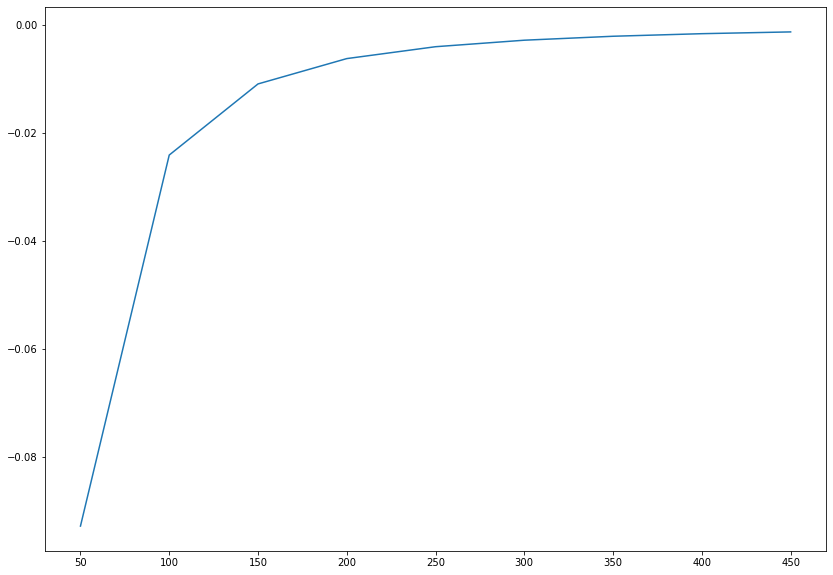

In [15]:
plt.figure(figsize=(14,10))
plt.plot(df['S_steps'], df['error_cn'], '-', markersize=3)
plt.savefig('Images/cnadvus.png')
plt.show()

Do note how when you double the number of S steps the error reduces by around a factor of 4, showing the very fast, smooth convergence of the CN model. Also notice, however, that the values are actually slightly LESS accurate than those from the simpler model. I must admit that I find that unexpected...